In [3]:


class Notreal_normalized(gym.Env):
    """ will remove the stoichastic part of the system """
    def __init__(self,render_mode="human"):
        super(Notreal_normalized, self).__init__()
        # State is [y1, y2]
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float64)
        
        # Actions are [u1, u2], both in some control range
        
# Actions are [I, Fn] - Light Intensity and Inflow Rate
        self.action_space = spaces.Box(low=0, high=1, dtype=np.float32)
        
                
        
        self.render_mode="human"
        # Time step for numerical integration
        self.dt = 0.1
        
        # Initial values for state variables y1 and y2
        #self.state = np.array([1, 1])  # You  set this based on the problem
        self.state = np.array([1 , 150 , 0])
        
        self.um= .0572
        self.ud=0.0
        self.Kn= 393.1
        self.Ynx=504.1
        self.km=.000016
        self.kd=0.281
        self.ks=178.9
        self.ki=447.1
        self.ksq=23.51
        self.kiq=800
        self.Knp=16.89
        
        #the manipulated variables are light intelfnsity I and inflow rate Fn
        
        #values for normalizatrion
        self.action_low = np.array([120, 0])
        self.action_high = np.array([400, 40])
        
        
        self.max_CX=1000
        self.max_CN=10000
        self.max_CQ=100
        
        
        
        self.max_episodes=1000
        self.cureent_episode=0        
        
        
        
    def denormalize_action(self, action) -> np.ndarray:
        """ Convert the normalized action [-1, 1] to the original scale [0, 400] and [0, 40] """
        
        return 0.5 * (action + 1) * (self.action_high - self.action_low) + self.action_low

            
        
    def normalize_state(self, state) -> np.ndarray:
        """ Convert the state to a normalized form """
        return state / np.array([self.max_CX, self.max_CN, self.max_CQ])
        
    def dernomalize_state(self, state) -> np.ndarray:
        """ Convert the state to a normalized form """
        return state * np.array([self.max_CX, self.max_CN, self.max_CQ])
                
        
        
        
    def reset(self, seed=None, options=None):
        # Reset the state to initial values
        self.state = self.normalize_state(np.array([1, 150, 0]))
        #self.state = np.array([1 , 150 , 0])
        self.cureent_episode = 0
        self.REWARD=0

        # Return the observation and an empty info dictionary
        return self.state  , {}
        
        #change self. state ?

    


    def step(self, action):
        
        L, Fn =  self.denormalize_action(action)
        #L, Fn =  action

        cx,cn,cq = self.dernomalize_state(self.state)
        
        
        dt = self.dt
        u_m=self.um
        k_s=self.ks 
        K_N=self.Kn
        k_i=self.ki
        x=cx
        n=cn 
        u_d=self.ud
        Y_nx=self.Ynx
        k_m=self.km
        k_sq=self.ksq
        k_iq=self.kiq
        k_d=self.kd
        q=cq
        K_Np=self.Knp


        
                

        dx   = u_m * L/(L+k_s+L**2./k_i) * x * n/(n+K_N) - u_d*x
        dn   = - Y_nx*u_m* L/(L+k_s+L**2./k_i) * x * n/(n+K_N)+ Fn
        dq   = (k_m * L/(L+k_sq+L**2./k_iq) * x - k_d * q/(n+K_Np)) * (np.sign(500. - n)+1)/2 * (np.sign(x - 10.0)+1)/2       
         
        # Update states
        
        cx+=(dx * dt)
        cn+=(dn * dt)
        cq+=(dq * dt)
        
        
                
        #so what is the sign function ? 
        
        # Ensure non-negative concentrations
        #y1 = max(0, y1)
        #y2 = max(0, y2)
        
        self.state =self.normalize_state((np.array([cx,cn,cq])))
        
        # Reward is based on maximizing y2
        reward = (dq*dt) *1000 if cq >  0 else 0
        
        
        
        # Done if the system has run too long or if values go out of bounds
        done = False
        
       #changing the negative reward (Reducing it ) 
        if cn<0  or cx < 0 or cq < 0 :
            reward = -5  #changeing the reward to -1 from -1000
            done = True
        
        self.cureent_episode+=1
        if self.cureent_episode>=self.max_episodes:
            done = True
            
        #this is extra for the PPO case, im adding a negative reward at the end if Cq is 0 
         
        # if self.cureent_episode>=self.max_episodes -1 :
        #     done = True
        #     if cq==0:
        #         reward=-10
        
        
        self.REWARD+=reward
        
        return self.state, reward, done,False, {}
    

        # Optional rendering for visualization, not essential
    def render(self):
        if self.render_mode == "human":
            print(f"Current state: {self.dernomalize_state(self.state) } Total_Reward={self.REWARD} ")
            return(str("Current state: {self.dernomalize_state(self.state) } Total_Reward={self.REWARD})" ))
            # You can add more sophisticated rendering here, such as creating a graphical window.
        elif self.render_mode == "rgb_array":
            # Return an RGB array representation if needed for video recording or display
            pass
        elif self.render_mode == "ansi":
            return str(self.state)  # For text-based environments
        
        
enviorment_N=Notreal()
enviorment_N.reset()
done=False

In [9]:
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback

# class RenderCallback(BaseCallback):
#     """
#     A custom callback that renders the environment during training.
#     """
#     def __init__(self, render_freq=1000, verbose=0):
#         super(RenderCallback, self).__init__(verbose)
#         self.render_freq = render_freq

#     def _on_step(self) -> bool:
#         if self.n_calls % self.render_freq == 0:
#             self.training_env.render()
#         return True

class RenderCallback(BaseCallback):
    def __init__(self, render_freq=1000, verbose=0, log_file='log.txt'):
        super(RenderCallback, self).__init__(verbose)
        self.render_freq = render_freq
        self.log_file = log_file

    def _on_step(self) -> bool:
        if self.n_calls % self.render_freq == 0:
            render_output = self.training_env.render()
            with open(self.log_file, 'a') as f:
                f.write(f"Step: {self.n_calls}, Render Output: {render_output}\n")
        return True
# Initialize the environment






In [ ]:
# Create the SAC model

#Lets train  a new model 
nodel = SAC(
    "MlpPolicy", enviorment, 
    learning_rate=3e-4,     
    buffer_size=int(1e6), 
    batch_size=1024,       
    tau=0.005,            
    gamma=0.99,           
    train_freq=(1000 , "step"),         
    gradient_steps=-1,     
    ent_coef="auto",
    verbose=1         # Enable logging
)
nodel.learn(total_timesteps=500000, progress_bar=True)
nodel.save("SAConNotrealV2.zip")

In [ ]:
nodelV3 = SAC(
    "MlpPolicy", enviorment, 
    learning_rate=3e-4,     
    buffer_size=int(1e6), 
    batch_size=1024,       
    tau=0.005,            
    gamma=0.99,           
    #train_freq=(1000 , "step"),         
    #gradient_steps=10,     
    ent_coef="auto_0.5",
    verbose=1         # Enable logging
)
nodelV3.learn(total_timesteps=500000, progress_bar=True)
nodelV3.save("SAConNotrealV3_1000episodse.zip")

In [4]:
from stable_baselines3 import SAC 
nodelV3=SAC.load("SAConNotrealV3_1000episodse.zip")

In [201]:
enviorment.reset()[0]

array([0.001, 0.015, 0.   ])

In [ ]:
action=nodel.predict(enviorment.reset()[0])
obs, reward, done, _, _ = enviorment.step(action)
obs



In [43]:
action[0]

array([ 0.26242507, -0.05903226], dtype=float32)

#using ppo this time

In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# Wrap your environment in DummyVecEnv
env = DummyVecEnv([lambda: enviorment])
# Now apply VecNormalize to normalize observations and rewards
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)
model_PPO= PPO("MlpPolicy", env, verbose=1)

Using cpu device


In [6]:
model_PPO.learn(total_timesteps=100000,progress_bar=True)
model_PPO.save("PPOonNotrealV1.zip")

Output()

-----------------------------
| time/              |      |
|    fps             | 1718 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 1262         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0058630207 |
|    clip_fraction        | 0.0449       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.89        |
|    explained_variance   | -0.0157      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0212       |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.00214     |
|    std                  | 1.03         |
|    value_loss           | 0.759        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 1123        |
|    iterations           | 3           |
|    time_elapsed         | 5           |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.002564901 |
|    clip_fraction        | 0.0175      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.92       |
|    explained_variance   | 0.143       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.479       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.000749   |
|    std                  | 1.05        |
|    value_loss           | 0.67        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 1081         |
|    iterations           | 4            |
|    time_elapsed         | 7            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0028380256 |
|    clip_fraction        | 0.00464      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.94        |
|    explained_variance   | 0.407        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.107        |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.000128    |
|    std                  | 1.05         |
|    value_loss           | 0.563        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 1059        |
|    iterations           | 5           |
|    time_elapsed         | 9           |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.004029928 |
|    clip_fraction        | 0.0207      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.94       |
|    explained_variance   | 0.506       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.539       |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00121    |
|    std                  | 1.06        |
|    value_loss           | 0.515       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 1043        |
|    iterations           | 6           |
|    time_elapsed         | 11          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.006755503 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.95       |
|    explained_variance   | 0.651       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.114       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00525    |
|    std                  | 1.06        |
|    value_loss           | 0.435       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 1034        |
|    iterations           | 7           |
|    time_elapsed         | 13          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.005923759 |
|    clip_fraction        | 0.0598      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.96       |
|    explained_variance   | 0.614       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0277      |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00466    |
|    std                  | 1.06        |
|    value_loss           | 0.482       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 1024         |
|    iterations           | 8            |
|    time_elapsed         | 15           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0069870786 |
|    clip_fraction        | 0.0363       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.96        |
|    explained_variance   | 0.607        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.155        |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.0015      |
|    std                  | 1.06         |
|    value_loss           | 0.505        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 1011         |
|    iterations           | 9            |
|    time_elapsed         | 18           |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0026396308 |
|    clip_fraction        | 0.0211       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.95        |
|    explained_variance   | 0.683        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0678       |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.000344    |
|    std                  | 1.06         |
|    value_loss           | 0.472        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 997          |
|    iterations           | 10           |
|    time_elapsed         | 20           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0020985706 |
|    clip_fraction        | 0.0143       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.94        |
|    explained_variance   | 0.726        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.164        |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00082     |
|    std                  | 1.05         |
|    value_loss           | 0.451        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 990         |
|    iterations           | 11          |
|    time_elapsed         | 22          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.008088981 |
|    clip_fraction        | 0.0606      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.93       |
|    explained_variance   | 0.726       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.153       |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0031     |
|    std                  | 1.04        |
|    value_loss           | 0.444       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 956         |
|    iterations           | 12          |
|    time_elapsed         | 25          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.009490788 |
|    clip_fraction        | 0.094       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.92       |
|    explained_variance   | 0.776       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.309       |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.006      |
|    std                  | 1.04        |
|    value_loss           | 0.436       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 907          |
|    iterations           | 13           |
|    time_elapsed         | 29           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0061172624 |
|    clip_fraction        | 0.036        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.91        |
|    explained_variance   | 0.677        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.925        |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.000839    |
|    std                  | 1.03         |
|    value_loss           | 0.528        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 862         |
|    iterations           | 14          |
|    time_elapsed         | 33          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.011655583 |
|    clip_fraction        | 0.0945      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.9        |
|    explained_variance   | 0.776       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.114       |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00424    |
|    std                  | 1.04        |
|    value_loss           | 0.451       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 845          |
|    iterations           | 15           |
|    time_elapsed         | 36           |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0110586155 |
|    clip_fraction        | 0.0892       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.9         |
|    explained_variance   | 0.708        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0319       |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00506     |
|    std                  | 1.03         |
|    value_loss           | 0.556        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 825         |
|    iterations           | 16          |
|    time_elapsed         | 39          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.012187524 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.9        |
|    explained_variance   | 0.642       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0422      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0068     |
|    std                  | 1.04        |
|    value_loss           | 0.526       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 17           |
|    time_elapsed         | 42           |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0048304684 |
|    clip_fraction        | 0.0326       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.9         |
|    explained_variance   | 0.583        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0387       |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.000978    |
|    std                  | 1.03         |
|    value_loss           | 0.57         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 796          |
|    iterations           | 18           |
|    time_elapsed         | 46           |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0084413225 |
|    clip_fraction        | 0.0834       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.89        |
|    explained_variance   | 0.77         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0646       |
|    n_updates            | 180          |
|    policy_gradient_loss | -0.00424     |
|    std                  | 1.03         |
|    value_loss           | 0.416        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 791          |
|    iterations           | 19           |
|    time_elapsed         | 49           |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0066095274 |
|    clip_fraction        | 0.0491       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.89        |
|    explained_variance   | 0.796        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.741        |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00228     |
|    std                  | 1.02         |
|    value_loss           | 0.364        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 786          |
|    iterations           | 20           |
|    time_elapsed         | 52           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0032163735 |
|    clip_fraction        | 0.0155       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.87        |
|    explained_variance   | 0.757        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0373       |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00051     |
|    std                  | 1.01         |
|    value_loss           | 0.44         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 782          |
|    iterations           | 21           |
|    time_elapsed         | 54           |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0035728803 |
|    clip_fraction        | 0.0362       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | 0.775        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.258        |
|    n_updates            | 210          |
|    policy_gradient_loss | 0.000398     |
|    std                  | 1.01         |
|    value_loss           | 0.528        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 776         |
|    iterations           | 22          |
|    time_elapsed         | 58          |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.004450764 |
|    clip_fraction        | 0.0348      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | 0.838       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.314       |
|    n_updates            | 220         |
|    policy_gradient_loss | 0.000284    |
|    std                  | 0.992       |
|    value_loss           | 0.338       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 769          |
|    iterations           | 23           |
|    time_elapsed         | 61           |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0023489771 |
|    clip_fraction        | 0.0398       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.862        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.295        |
|    n_updates            | 230          |
|    policy_gradient_loss | 0.000517     |
|    std                  | 0.989        |
|    value_loss           | 0.291        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 766          |
|    iterations           | 24           |
|    time_elapsed         | 64           |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0047214967 |
|    clip_fraction        | 0.0394       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | 0.934        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0541       |
|    n_updates            | 240          |
|    policy_gradient_loss | 0.000375     |
|    std                  | 0.994        |
|    value_loss           | 0.186        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 760         |
|    iterations           | 25          |
|    time_elapsed         | 67          |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.006223678 |
|    clip_fraction        | 0.0368      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.261       |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00103    |
|    std                  | 0.994       |
|    value_loss           | 0.193       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 757          |
|    iterations           | 26           |
|    time_elapsed         | 70           |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0048128553 |
|    clip_fraction        | 0.049        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | 0.92         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0922       |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00054     |
|    std                  | 0.994        |
|    value_loss           | 0.206        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 751          |
|    iterations           | 27           |
|    time_elapsed         | 73           |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0037136907 |
|    clip_fraction        | 0.0137       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | 0.92         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.131        |
|    n_updates            | 270          |
|    policy_gradient_loss | 0.000837     |
|    std                  | 0.995        |
|    value_loss           | 0.212        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 745         |
|    iterations           | 28          |
|    time_elapsed         | 76          |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.003989488 |
|    clip_fraction        | 0.0481      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0364      |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00174    |
|    std                  | 0.987       |
|    value_loss           | 0.165       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 741          |
|    iterations           | 29           |
|    time_elapsed         | 80           |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0049091913 |
|    clip_fraction        | 0.0697       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.934        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00265      |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.00443     |
|    std                  | 0.995        |
|    value_loss           | 0.175        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 736         |
|    iterations           | 30          |
|    time_elapsed         | 83          |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.002593506 |
|    clip_fraction        | 0.0269      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.033       |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.000808   |
|    std                  | 0.995       |
|    value_loss           | 0.156       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 735          |
|    iterations           | 31           |
|    time_elapsed         | 86           |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0063958014 |
|    clip_fraction        | 0.0521       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.95         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00737      |
|    n_updates            | 310          |
|    policy_gradient_loss | -0.00151     |
|    std                  | 0.986        |
|    value_loss           | 0.141        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 732          |
|    iterations           | 32           |
|    time_elapsed         | 89           |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0023791501 |
|    clip_fraction        | 0.0409       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.79        |
|    explained_variance   | 0.958        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0807       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.00171     |
|    std                  | 0.976        |
|    value_loss           | 0.124        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 733          |
|    iterations           | 33           |
|    time_elapsed         | 92           |
|    total_timesteps      | 67584        |
| train/                  |              |
|    approx_kl            | 0.0037705787 |
|    clip_fraction        | 0.0275       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.77        |
|    explained_variance   | 0.967        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0659       |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.000343    |
|    std                  | 0.966        |
|    value_loss           | 0.0956       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 734         |
|    iterations           | 34          |
|    time_elapsed         | 94          |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.006073826 |
|    clip_fraction        | 0.0476      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.74       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.129       |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00351    |
|    std                  | 0.952       |
|    value_loss           | 0.103       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 736          |
|    iterations           | 35           |
|    time_elapsed         | 97           |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0058766557 |
|    clip_fraction        | 0.0598       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.72        |
|    explained_variance   | 0.972        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0536       |
|    n_updates            | 350          |
|    policy_gradient_loss | -0.00496     |
|    std                  | 0.947        |
|    value_loss           | 0.082        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 736         |
|    iterations           | 36          |
|    time_elapsed         | 100         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.002528055 |
|    clip_fraction        | 0.0381      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.45e-05    |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.000211   |
|    std                  | 0.956       |
|    value_loss           | 0.124       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 739         |
|    iterations           | 37          |
|    time_elapsed         | 102         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.003846954 |
|    clip_fraction        | 0.0403      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.72       |
|    explained_variance   | 0.942       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.151       |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00252    |
|    std                  | 0.944       |
|    value_loss           | 0.145       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 737          |
|    iterations           | 38           |
|    time_elapsed         | 105          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0054919193 |
|    clip_fraction        | 0.0626       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.7         |
|    explained_variance   | 0.966        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0904       |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.00226     |
|    std                  | 0.939        |
|    value_loss           | 0.103        |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 739         |
|    iterations           | 39          |
|    time_elapsed         | 108         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.004781944 |
|    clip_fraction        | 0.0653      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.71       |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0492      |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.00143    |
|    std                  | 0.951       |
|    value_loss           | 0.119       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 740         |
|    iterations           | 40          |
|    time_elapsed         | 110         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.006595591 |
|    clip_fraction        | 0.0814      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0504      |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.00273    |
|    std                  | 0.955       |
|    value_loss           | 0.115       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 738         |
|    iterations           | 41          |
|    time_elapsed         | 113         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.004354905 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0545      |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00298    |
|    std                  | 0.954       |
|    value_loss           | 0.131       |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 736          |
|    iterations           | 42           |
|    time_elapsed         | 116          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0028484506 |
|    clip_fraction        | 0.0394       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.74        |
|    explained_variance   | 0.979        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00015     |
|    n_updates            | 420          |
|    policy_gradient_loss | -0.00101     |
|    std                  | 0.966        |
|    value_loss           | 0.0641       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 735          |
|    iterations           | 43           |
|    time_elapsed         | 119          |
|    total_timesteps      | 88064        |
| train/                  |              |
|    approx_kl            | 0.0036130846 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.75        |
|    explained_variance   | 0.978        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0426       |
|    n_updates            | 430          |
|    policy_gradient_loss | 0.000304     |
|    std                  | 0.97         |
|    value_loss           | 0.0687       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 732          |
|    iterations           | 44           |
|    time_elapsed         | 122          |
|    total_timesteps      | 90112        |
| train/                  |              |
|    approx_kl            | 0.0043731653 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.76        |
|    explained_variance   | 0.981        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0448       |
|    n_updates            | 440          |
|    policy_gradient_loss | 0.000132     |
|    std                  | 0.971        |
|    value_loss           | 0.0596       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 732          |
|    iterations           | 45           |
|    time_elapsed         | 125          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0039198804 |
|    clip_fraction        | 0.034        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.76        |
|    explained_variance   | 0.983        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0777       |
|    n_updates            | 450          |
|    policy_gradient_loss | -0.000996    |
|    std                  | 0.963        |
|    value_loss           | 0.052        |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 730          |
|    iterations           | 46           |
|    time_elapsed         | 128          |
|    total_timesteps      | 94208        |
| train/                  |              |
|    approx_kl            | 0.0048299353 |
|    clip_fraction        | 0.0405       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.75        |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0255       |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.00221     |
|    std                  | 0.964        |
|    value_loss           | 0.0495       |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 729          |
|    iterations           | 47           |
|    time_elapsed         | 131          |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0021994188 |
|    clip_fraction        | 0.0319       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.75        |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00429      |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.000394    |
|    std                  | 0.962        |
|    value_loss           | 0.0497       |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 726         |
|    iterations           | 48          |
|    time_elapsed         | 135         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.006502881 |
|    clip_fraction        | 0.049       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.74       |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0198      |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.00296    |
|    std                  | 0.954       |
|    value_loss           | 0.0449      |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 722          |
|    iterations           | 49           |
|    time_elapsed         | 138          |
|    total_timesteps      | 100352       |
| train/                  |              |
|    approx_kl            | 0.0049586194 |
|    clip_fraction        | 0.0472       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.73        |
|    explained_variance   | 0.983        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0808       |
|    n_updates            | 490          |
|    policy_gradient_loss | -0.00247     |
|    std                  | 0.95         |
|    value_loss           | 0.0508       |
------------------------------------------


In [62]:
enviorment.reset()[0]

array([0.001, 0.015, 0.   ])

In [39]:
import matplotlib.pyplot as plt

# Initialize lists for storing time steps and actions
actions = []
time_steps = []
model_PPO= PPO.load("PPOonNotrealV1.zip",env=env)
# Reset the environment
obs = env.reset()[0]

# Loop through time steps
for t in range(1000):
    action, _ = model_PPO.predict(obs)  # Predict action from the model
    print(type(action))
    obs, reward, done, _, _ = env.step(np.ndarray([120 , 0]))  # Step in the environment with the chosen action
    
    # Store the current time step and action
    time_steps.append(t)
    actions.append(action[0])  # Adjust index if the action is multidimensional

    # Reset environment if the episode is done
    if done:
        obs = env.reset()[0]

# Plot the actions over time
plt.plot(time_steps, actions)
plt.xlabel('Time Steps')
plt.ylabel('Actions')
plt.title('Model Actions Over Time')
plt.show()


<class 'numpy.ndarray'>
[]


ValueError: Action should be a list or array with exactly 2 values, [L, Fn]

In [18]:
action, _ = model_PPO.predict(obs)
print(action)  # To confirm the shape and contents of action
print(env.action_space.shape)


[120.   0.]
(2,)


In [17]:
for i in range(1):
    action=nodelV3.predict(enviorment_N.reset()[0])
    enviorment_N.step(action[0])
print(enviorment_N.step(action[0]))


(array([  0.99998224, 149.80895098,   0.        ]), 0, False, False, {})


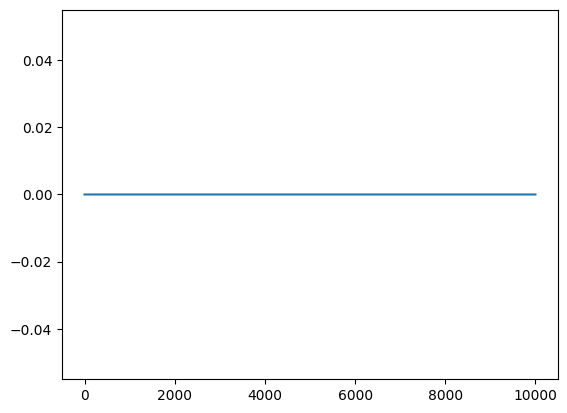

In [25]:
#for the sac code
a=[]
tt=[]
obs=enviorment_N.reset()[0]
for t in range(10000):
    action=nodelV3.predict(obs)
    obs, reward, done, _, _ = enviorment_N.step(action[0])
    tt.append(t)
    a.append((obs[2]))
plt.plot(tt,a)
    #print(enviorment

SO the problem is that the model cant seem to work well before 4k-6k timesteps? 

1024

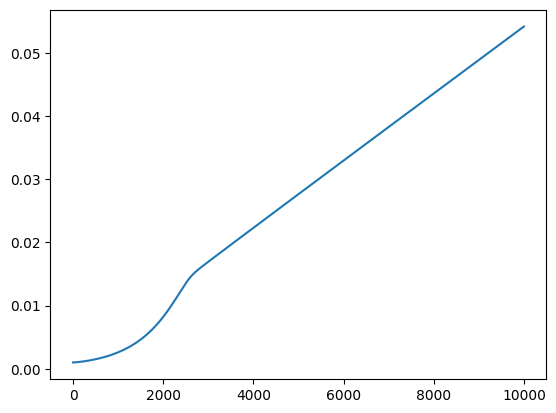

LETS USE PPO, THIS TIME THE ENVIORMENT IS REWARDED FOR GAIN, AND NEGATIVE REWARDED IF ENV CQ IS ZERO 